**TODOs**  
- [x] Challenge description
- [ ] Feature importance

* [Challenge description](#Challenge-description)
* [Data exploration](#Data-exploration)

## Challenge description

The goal for this week’s project is to build and train a regression model on the Capital Bike Share (Washington, D.C.) Kaggle data set, in order to predict demand for bicycle rentals at any given hour, based on time and weather, e.g.

**Data description**  
[https://www.kaggle.com/c/bike-sharing-demand](https://www.kaggle.com/c/bike-sharing-demand)

## Data exploration

### Load data

In [2]:
import pandas as pd
df = pd.read_csv('./data/train.csv', parse_dates=True, index_col=0)
df.tail()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129
2012-12-19 23:00:00,4,0,1,1,13.12,16.665,66,8.9981,4,84,88


<AxesSubplot:xlabel='datetime'>

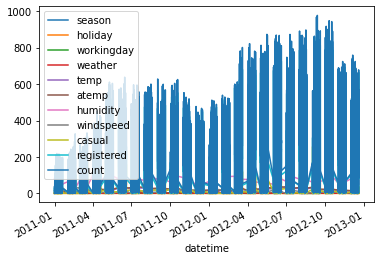

In [3]:
df.plot()

### Train/Test split

In [4]:
from sklearn.model_selection import train_test_split

RANDOM_STATE = 42

X = df[df.columns.difference(['count', 'registered', 'casual'])].copy(deep=True)
y = df[['count']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
X_train

,atemp,holiday,humidity,season,temp,weather,windspeed,workingday
datetime,,,,,,,,
2011-07-06 05:00:00,31.820,0,83,3,27.88,1,6.0032,1
2012-08-04 16:00:00,40.910,0,39,3,36.90,1,19.9995,0
2012-07-11 15:00:00,35.605,0,41,3,32.80,1,16.9979,1
2011-04-10 04:00:00,18.180,0,93,2,14.76,2,7.0015,0
2011-11-19 10:00:00,15.150,0,45,4,13.12,1,16.9979,0
...,...,...,...,...,...,...,...,...
2012-01-14 02:00:00,8.335,0,47,1,6.56,1,11.0014,0
2011-12-10 09:00:00,12.880,0,61,4,11.48,1,19.0012,0
2011-12-18 16:00:00,13.635,0,48,4,11.48,1,16.9979,0


### Heatmap

<AxesSubplot:>

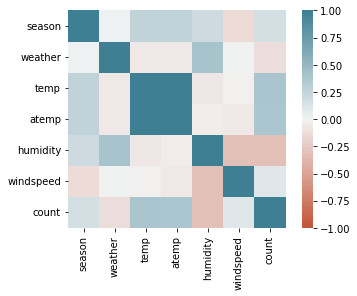

In [5]:
import seaborn as sns
tmp = df[['season', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'count']].reset_index()
sns.heatmap(
    tmp.corr(), 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    
)

### Pairplot

In [6]:
import seaborn as sns
from pathlib import Path
from IPython import display
from IPython.core.display import display, HTML

PAIRPLOT_FROM = '2012-01-01'
PAIRPLOT_TO = '2013-01-01'
filename = "./output/pairplot-" + PAIRPLOT_FROM + " --" + PAIRPLOT_TO + ".png"

# Drawing a pairplot takes several minutes, that's why better to save (cache) image once it's created for the first time
file = Path(filename)
if not file.is_file():
    tmp = df.loc[PAIRPLOT_FROM:PAIRPLOT_TO, ['atemp', 'temp', 'humidity', 'season', 'weather', 'windspeed', 'count']]
    tmp = extract_datetime_data(tmp) # TODO: move this function to the top
    plot = sns.pairplot(tmp, hue='count')
    plot.savefig(file)
else:
    display(HTML('<img src="'+filename+'"></img>'))
#     display.Image(filename) # not working :(


### Check NaN values

In [7]:
X_train.isna().sum()

atemp         0
holiday       0
humidity      0
season        0
temp          0
weather       0
windspeed     0
workingday    0
dtype: int64

Note: on a heatmap above we can clearly see two hightly correlated variables - temp and atemp. We will use only one of them (temp) in the model.

In [8]:
# TODO: ask about "weather" and "season" variables - does it make sense to have them in the heatmap?

### Average count by hour

<AxesSubplot:xlabel='datetime'>

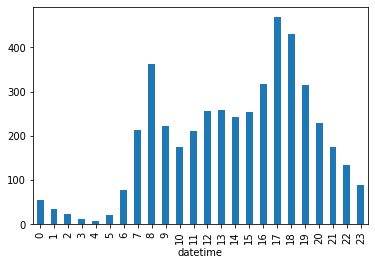

In [9]:
df.groupby(df.index.hour)['count'].mean().plot.bar()

### Average count by day of the week

<AxesSubplot:xlabel='datetime'>

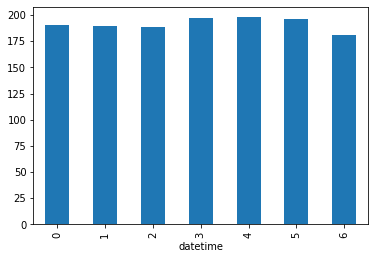

In [10]:
df.groupby(df.index.day_of_week)['count'].mean().plot.bar()

### Total count by month

<AxesSubplot:xlabel='datetime'>

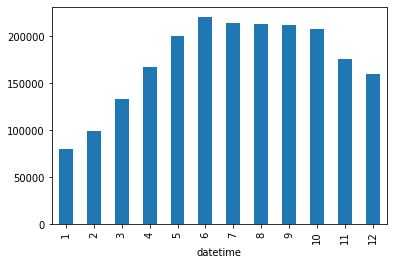

In [11]:
df.groupby(df.index.month)['count'].sum().plot.bar()

### Count in a last week

<AxesSubplot:xlabel='datetime'>

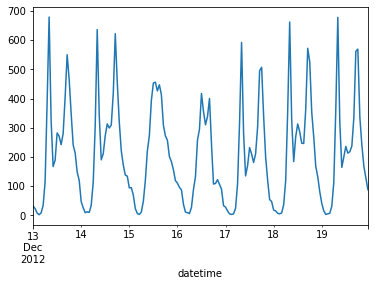

In [12]:
df.loc['2012-12-13 00:00:00':'2012-12-20 00:00:00']['count'].plot()

## Feature engineering

#### Build data pipeline

In [13]:
# tmp
# tmp = df.groupby(df.index.hour)['count'].mean().sort_values().reset_index().drop(columns="count")
# hour_weight_dict = pd.DataFrame({'values': tmp.index.tolist()}, index = tmp['datetime']) # TODO: ask how to do it simpler
# hour_weight_dict.sort_index(inplace=True)
# hour_weight_dict
hour_weight_dict = {
    0:5,1:4,2:3,3:1,4:0,5:2,6:6,7:12,8:21,9:13,10:10,11:11,12:17,13:18,14:15,15:16,16:20,17:23,18:22,19:19,20:14,21:9,22:8,23:7
}
# hour_weight_dict = pd.Series(hour_weight_dict.any())
# hour_weight_dict

# hour_weight_dict = pd.Series(tmp.index.tolist()) # TODO: ask how to do it simpler
# hour_weight_dict

# tmp = df.groupby(df.index.month)['count'].mean().sort_values().reset_index().drop(columns="count")
month_weight_dict = {0:1, 1: 2, 2: 3, 3:12, 4: 4, 5: 11, 6: 5, 7: 10, 8: 9, 9: 8, 10: 7, 11:6}

In [14]:
def extract_datetime_data(df: pd.DataFrame) -> pd.DataFrame:
    df = pd.DataFrame(df)
    df['hour'] = df.index.hour.map(hour_weight_dict)
    df['weekday'] = df.index.weekday
    df['month'] = df.index.month.map(month_weight_dict)

    return df

# TODO: add assertion

In [16]:
import sklearn.pipeline as pipeline
from sklearn.preprocessing import FunctionTransformer
datetime_pipeline = pipeline.make_pipeline(
    FunctionTransformer(extract_datetime_data)
)

In [17]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler

preprocessor = ColumnTransformer([
    ('extract_datetime_data', datetime_pipeline, ['season']),
    ('min_max_scaler', MinMaxScaler(), ['temp', 'humidity', 'windspeed']),
    ('do_nothing', 'passthrough', ['season', 'weather'])
])

#### Transform data

In [18]:
X_train.tail()

,atemp,holiday,humidity,season,temp,weather,windspeed,workingday
datetime,,,,,,,,
2012-01-14 02:00:00,8.335,0,47,1,6.56,1,11.0014,0
2011-12-10 09:00:00,12.880,0,61,4,11.48,1,19.0012,0
2011-12-18 16:00:00,13.635,0,48,4,11.48,1,16.9979,0
2011-02-19 07:00:00,19.695,0,17,1,15.58,1,35.0008,0
2012-05-02 07:00:00,25.760,0,88,2,22.14,2,12.9980,1


In [21]:
preprocessor.fit(X_train)

X_train_fe = preprocessor.transform(X_train)
X_test_fe = preprocessor.transform(X_test)

pd.DataFrame(X_train_fe).tail()
# pd.DataFrame(y_train)

Traceback (most recent call last):
  File "/Applications/PyCharm.app/Contents/plugins/python/helpers-pro/jupyter_debug/pydev_jupyter_utils.py", line 64, in attach_to_debugger
    debugger.prepare_to_run(enable_tracing_from_start=False)
TypeError: prepare_to_run() got an unexpected keyword argument 'enable_tracing_from_start'
Failed to connect to target debugger.


,0,1,2,3,4,5,6,7,8
8703,1.0,3.0,5.0,2.0,0.142857,0.47,0.193018,1.0,1.0
8704,4.0,13.0,5.0,NaN,0.265306,0.61,0.333373,4.0,1.0
8705,4.0,20.0,6.0,NaN,0.265306,0.48,0.298225,4.0,1.0
8706,1.0,12.0,5.0,3.0,0.367347,0.17,0.614083,1.0,1.0
8707,2.0,12.0,2.0,11.0,0.530612,0.88,0.228047,2.0,2.0


In [20]:
weight_by_month_dict

NameError: name 'weight_by_month_dict' is not defined

#### Create Linear Regression model

In [ ]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression().fit(X_train_fe, y_train)

#### Predict results

In [ ]:
y_pred = lr_model.predict(X_test_fe)
y_pred

#### Evaluate model

In [ ]:
from sklearn.metrics import mean_squared_log_error
import numpy as np

def rmsle(p,a):
    return np.sqrt(mean_squared_log_error(p,a))

In [ ]:
print("RMSLE:", rmsle(y_pred, y_test))

In [ ]:
print("Coefficients:", lr_model.coef_)
print("Intercept   :", lr_model.intercept_)

print("train score :", lr_model.score(X_train_fe, y_train))
print("test score  :", lr_model.score(X_test_fe, y_test))